# Gradient descent implementations in SciPy Optimize.

## Needed Libraries import

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

## Helper functions for plots and output formatting


In [57]:
def plot(func, results_list, grid):
    if not isinstance(results_list, list):
        results_list = [results_list]

    x, y = np.meshgrid(np.linspace(grid[0], grid[1], 200), np.linspace(grid[0], grid[1], 200))

    z = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i, j] = func((x[i, j], y[i, j]))

    plt.figure()
    plt.contour(x, y, z, levels=30)

    for res in results_list:
        path = res.x_history
        plt.plot(path[:, 0], path[:, 1], label="GD path", marker='o')
        plt.plot(path[-1, 0], path[-1, 1], 'x', markersize=10)

    plt.xlim(grid)
    plt.ylim(grid)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()


def print_output(init, gd, func, grad, optimum, grid=(-6, 6)):
    res = gd(func, grad, init)
    error = np.linalg.norm(res.x - optimum)

    print(f"{'=' * 90}")
    print(f"Method: {gd.__name__}")
    print(f"Function: (x - 3)^2 + (y + 2)^2")
    print(f"Initial point: {init}")
    print(f"Real minimum: (3.0, -2.0)")
    print(f"{'=' * 90}")
    print(f"{'Method':<15} {'Found point':<20} {'f(x)':<10} {'Iterations':<15} {'Evals':<12} {'Error':<10}")
    print(f"{'-' * 90}")
    print(
        f"{'Stat':<15} ({res.x[0]:.3f}, {res.x[1]:.3f}) {" ":<5} {res.fun:<13.3f} {res.nit:<13} {res.nfev:<10} {error:<10.6f}")
    print(f"{'=' * 90}")

    plot(func, res, grid)

## Functions for research

### Symmetrical parabola

In [58]:
def func_sp(point):
    x, y = point
    return (x - 3) ** 2 + (y + 2) ** 2


def grad_sp(point):
    x, y = point
    return np.array([2 * (x - 3), 2 * (y + 2)])

### Rotated elliptical function

In [59]:
def func_re(point):
    x, y = point
    return (2 * (x + 2) ** 2) + (4 * x * y) + (3 * (y - 4) ** 2)


def grad_re(point):
    x, y = point
    return np.array([4 * (x + 2) + 4 * y, 4 * x + 6 * (y - 4)])

### Elliptical function with scale

In [60]:
def func_es(point):
    x, y = point
    return (8 * (x - 3) ** 2) + ((y + 1) ** 2)


def grad_es(point):
    x, y = point
    return np.array([16 * (x - 3), 2 * (y + 1)])

## Gradient Descent implementations with SciPy Optimize

### Minimize function provides interface to optimization algorithms, which are using adaptive learning rate.

In [61]:
def gd_adaptive_lr_opt(func, grad, init):
    x_history = [np.array(init, dtype=float)]

    def callback(xk):
        x_history.append(np.array(xk, dtype=float))

    result = opt.minimize(func, x0=init, jac=grad, method='BFGS', tol=1e-6, callback=callback)

    result.x_history = np.array(x_history)

    return result

### SciPy optimize supplies minimize_scalar function for line search, which can use different algorithms heuristics. We can use it to implement gradient descent with line search.

In [62]:
def gd_line_search_opt(func, grad, init, max_iter=1000, tol=1e-6):
    x = np.array(init, dtype=float)
    x_history = [x.copy()]
    f_history = [func(x)]
    nit = 0
    nfev = 1
    for i in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break

        def line_search_func(alpha):
            nonlocal nfev
            nfev += 1
            return func(x - alpha * g)

        res = opt.minimize_scalar(line_search_func, method='golden', tol=1e-6)

        x = x - res.x * g

        x_history.append(x.copy())
        f_val = func(x)
        f_history.append(f_val)
        nit += 1
        nfev += 1

        if np.linalg.norm(x_history[-1] - x_history[-2]) < tol:
            break

    return opt.OptimizeResult(
        x=x,
        fun=func(x),
        jac=grad(x),
        nit=nit,
        nfev=nfev,
        x_history=np.array(x_history),
        f_history=np.array(f_history)
    )

## Results

### Symmetrical parabola: $(x - 3)^2 + (y + 2)^2$

Method: gd_adaptive_lr_opt
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 0]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -2.000)       0.000         3             4          0.000000  


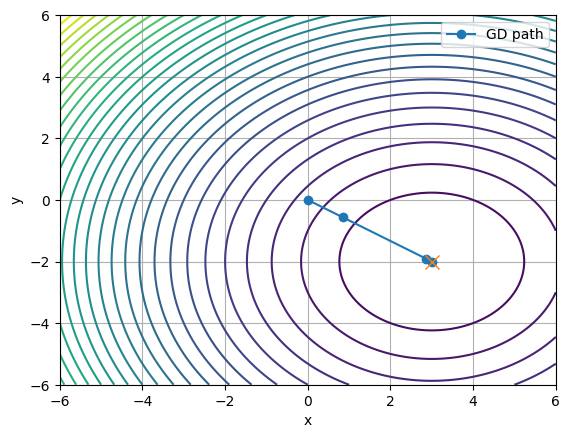

Method: gd_line_search_opt
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 0]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -2.000)       0.000         1             38         0.000000  


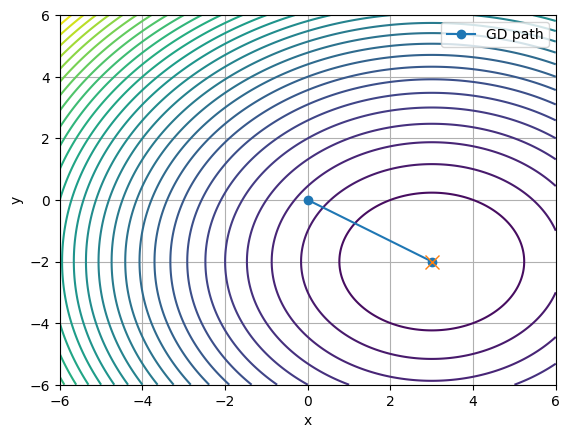

In [63]:
print_output([0, 0], gd_adaptive_lr_opt, func_sp, grad_sp, [3, -2])
print_output([0, 0], gd_line_search_opt, func_sp, grad_sp, [3, -2])

### Rotated elliptical function: $2(x + 2)^2 + 4xy + 3(y - 4)^2$

Method: gd_adaptive_lr_opt
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 1]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-18.000, 16.000)       -208.000      6             8          0.000000  


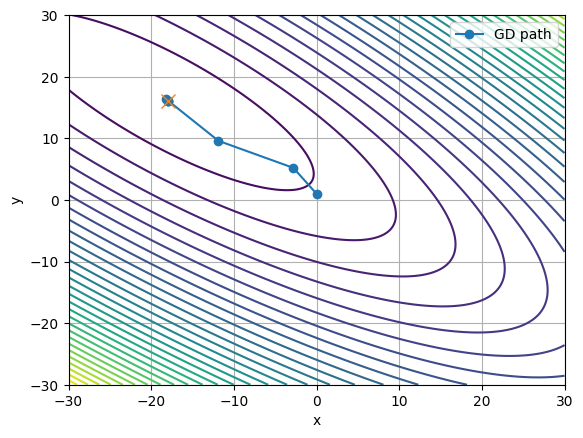

Method: gd_line_search_opt
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 1]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-18.000, 16.000)       -208.000      41            1580       0.000002  


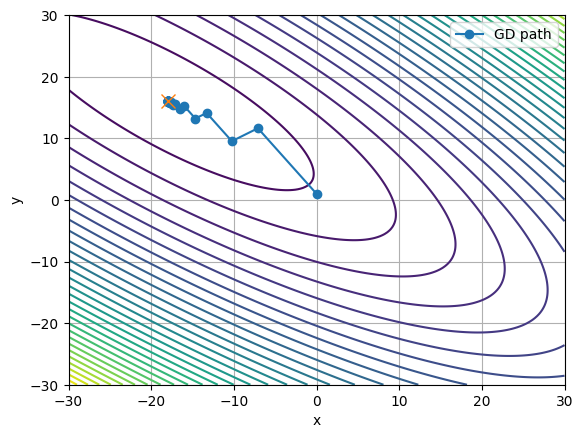

In [64]:
print_output([0, 1], gd_adaptive_lr_opt, func_re, grad_re, [-18, 16], [-30, 30])
print_output([0, 1], gd_line_search_opt, func_re, grad_re, [-18, 16], [-30, 30])

### Elliptical function with scale: $8(x - 3)^2 + (y + 1)^2$

Method: gd_adaptive_lr_opt
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 2]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -1.000)       0.000         6             7          0.000000  


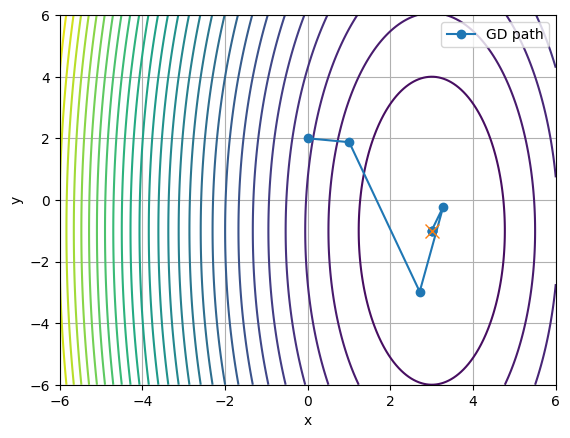

Method: gd_line_search_opt
Function: (x - 3)^2 + (y + 2)^2
Initial point: [0, 2]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -1.000)       0.000         14            554        0.000000  


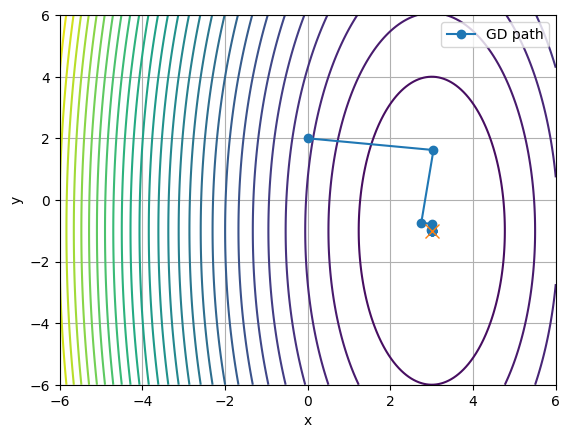

In [65]:
print_output([0, 2], gd_adaptive_lr_opt, func_es, grad_es, [3, -1])
print_output([0, 2], gd_line_search_opt, func_es, grad_es, [3, -1])